##  Contents:

### 0. Load packages and data

In [164]:
%matplotlib inline

# import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4


# import pandas as pd
# import numpy as np
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier
# from sklearn import cross_validation, metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation, metrics 


In [62]:
# Load the data (with features)
data = pd.read_csv("../feature_engineering/features.csv")

A quick peak to see everything loaded fine

In [3]:
data.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,len_intersection,len_intersection_sw,num_words_q1,...,cosine_distance_sentence_embeddings,cityblock_distance_sentence_embeddings,jaccard_distance_sentence_embeddings,braycurtis_distance_sentence_embeddings,q1_highest_tfidf_weight,q2_highest_tfidf_weight,q1_max_tf_idf_embedding,q2_max_tf_idf_embedding,euclidean_distance_max_tfidf_word,cosine_distance_max_tfidf_word
0,1,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,10,5,14,...,0.004921,3.938651,1.0,0.049871,guide,guide,[-0.028461 -0.34314999 0.23021001 -0.063865...,[-0.028461 -0.34314999 0.23021001 -0.063865...,0.000000,3.250036e-08
1,2,1,3,4,What is the story of Kohinoor Koh - i - Noor D...,What would happen if the Indian government sto...,0,2,0,10,...,0.027946,10.689272,1.0,0.129334,noor,noor,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,[ 3.72870006e-02 -3.17849994e-01 -2.3973000...,0.000000,4.103800e-08
2,3,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,3,2,14,...,0.010569,5.988954,1.0,0.075329,vpn,dns,[-0.14387 0.66254002 -0.23895 0.036253...,[ -4.19200003e-01 5.06489992e-01 -3.4162998...,5.495713,4.284846e-01
3,4,3,7,8,Why am I mentally very lonely ? How can I solv...,Find the remainder when math 23 24 math is div...,0,0,0,11,...,0.065936,15.007527,1.0,0.184240,mentally,remainder,[ -1.92690000e-01 -3.28700006e-01 -4.2276001...,[-0.39732999 -0.13798 0.21100999 0.237990...,4.781672,8.190252e-01
4,5,4,9,10,"Which one dissolve in water quickly sugar , sa...",Which fish would survive in salt water ?,0,3,2,13,...,0.038453,11.145288,1.0,0.142762,di,salt,[ -1.13650002e-01 -3.47779989e-02 8.1817999...,[-0.064408 -0.073121 -0.25946999 0.15424 ...,6.219034,8.441631e-01


#### 0.1 A look at the extracted features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1134f6fd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x127c2bfd0>]], dtype=object)

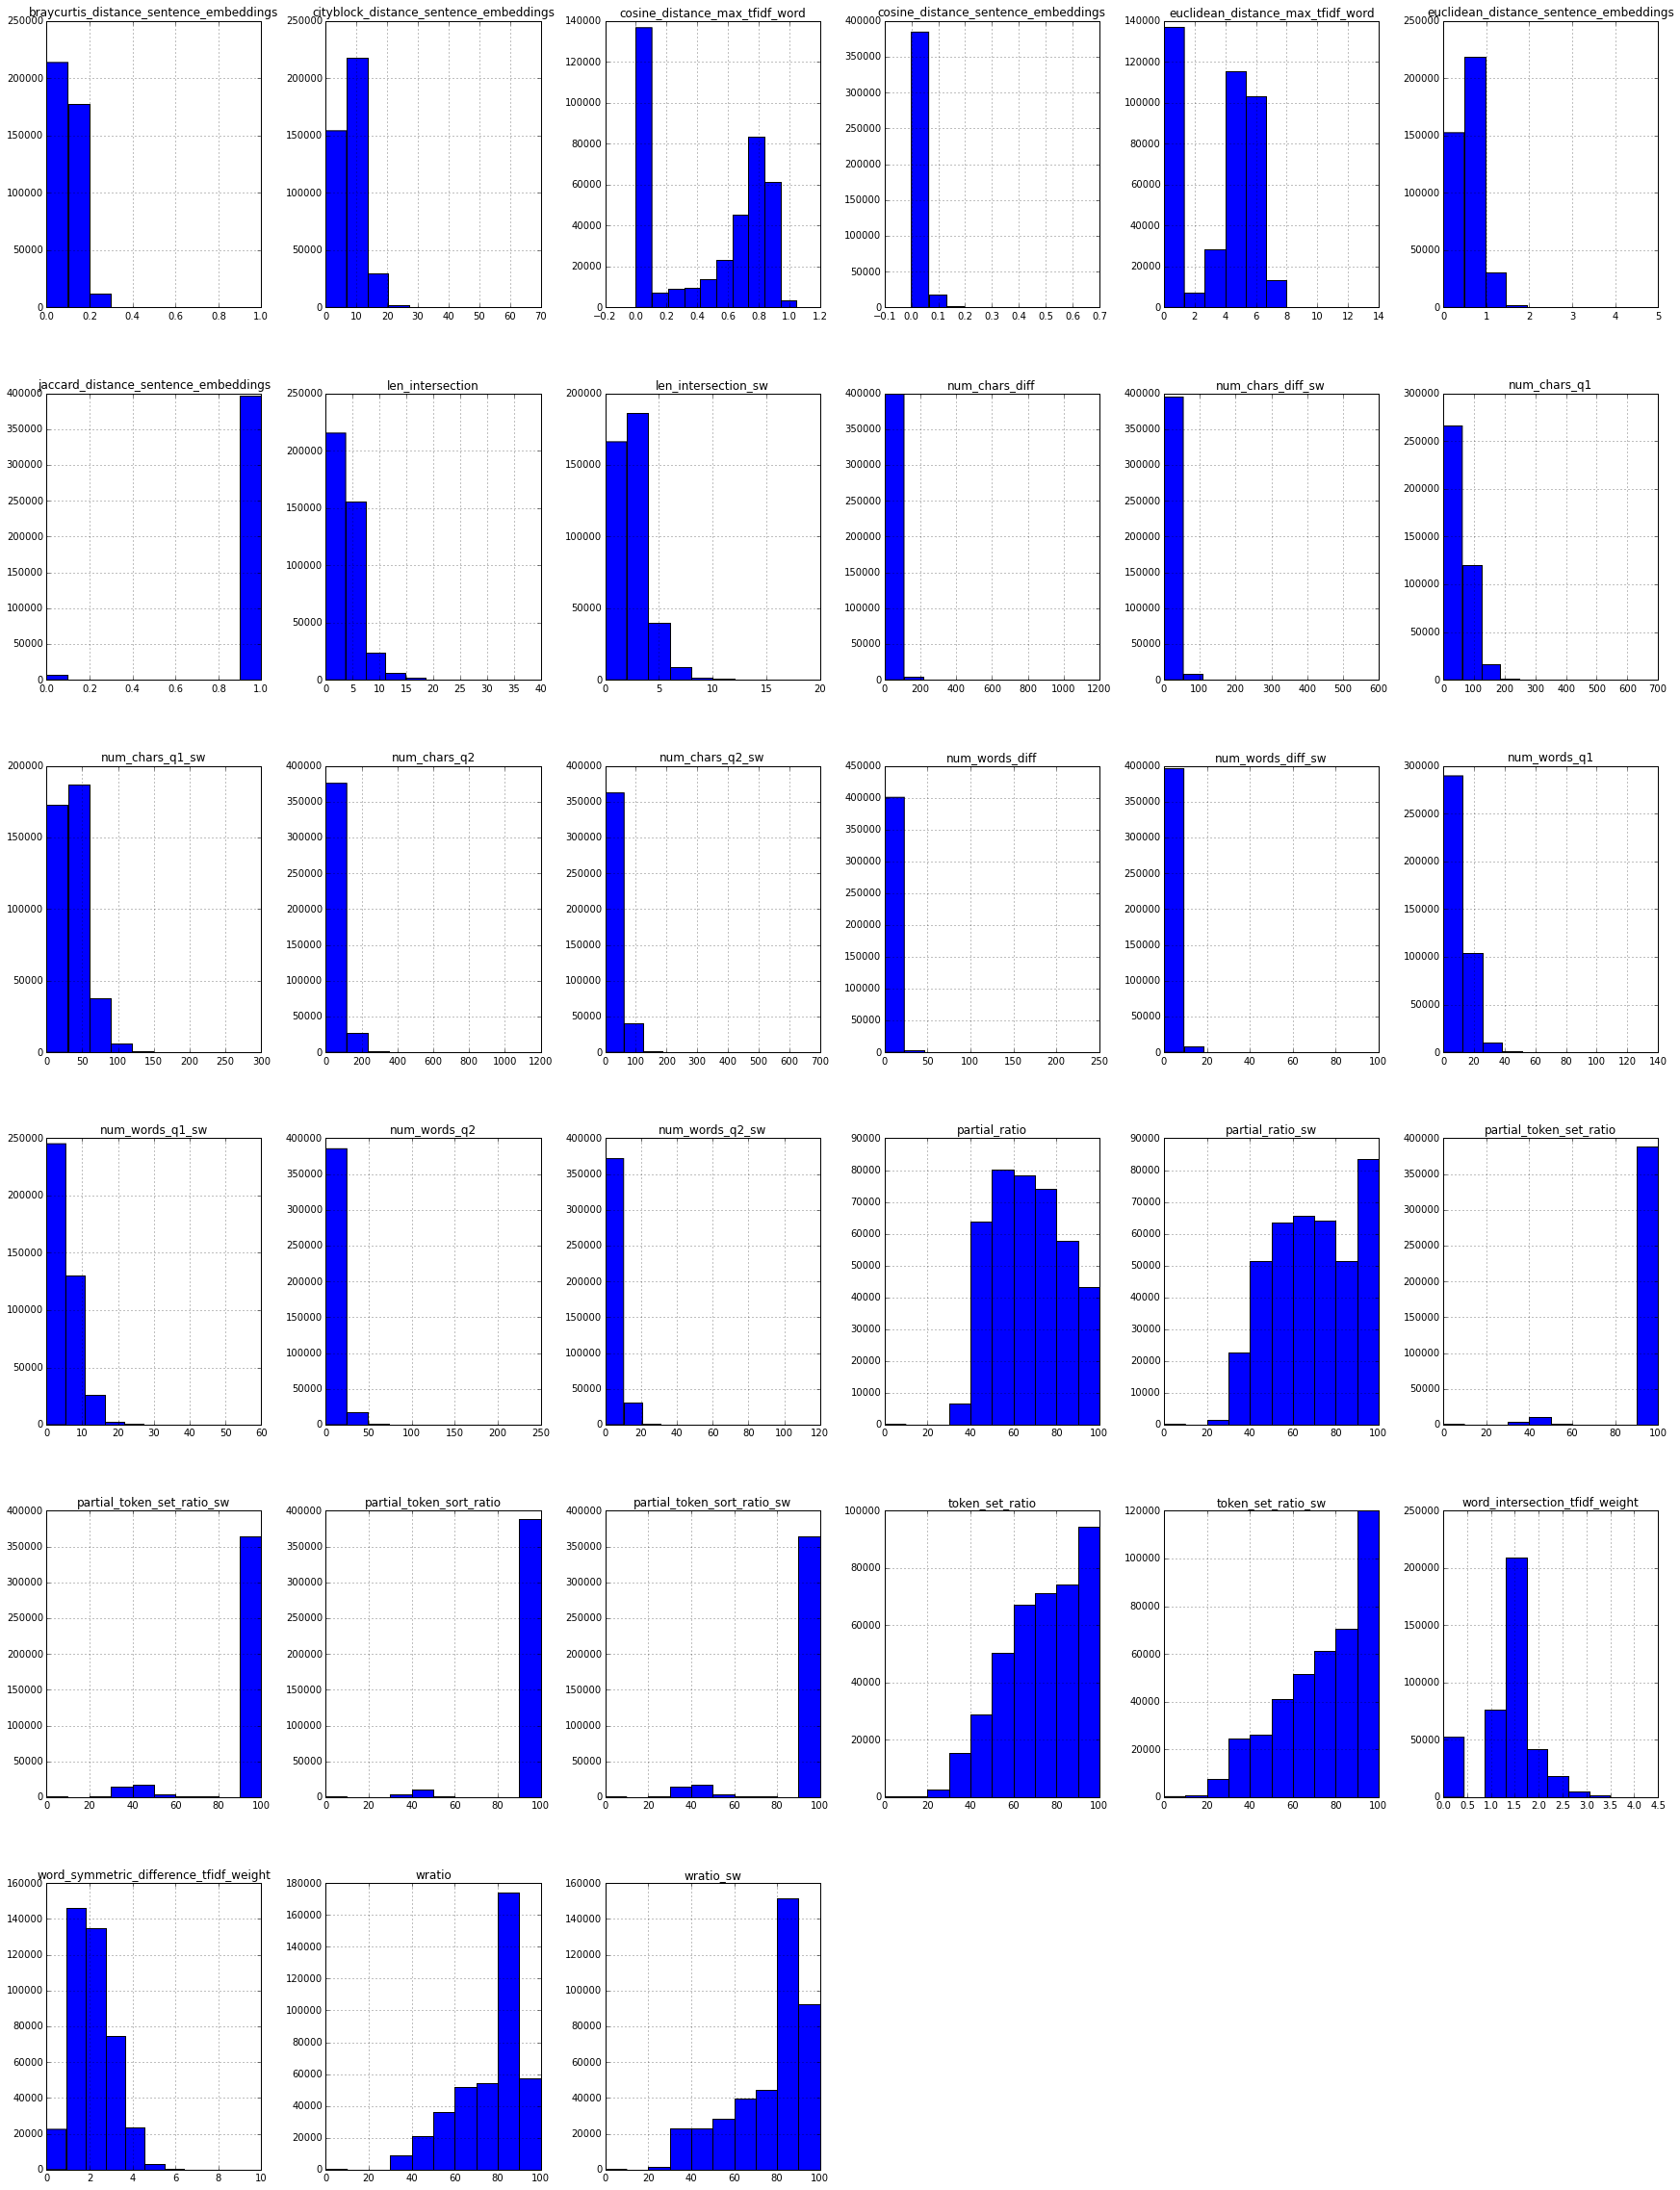

In [11]:
plt.figure()
data[[ u'len_intersection', u'len_intersection_sw',
       u'num_words_q1', u'num_words_q1_sw', u'num_words_q2',
       u'num_words_q2_sw', u'num_words_diff', u'num_words_diff_sw',
       u'num_chars_q1', u'num_chars_q1_sw', u'num_chars_q2',
       u'num_chars_q2_sw', u'num_chars_diff', u'num_chars_diff_sw',
       u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio',
       u'partial_token_set_ratio_sw', u'token_set_ratio',
       u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight', 
       u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_distance_sentence_embeddings', 
       u'euclidean_distance_max_tfidf_word',
       u'cosine_distance_max_tfidf_word']].hist(figsize=(30, 40))

### 1.0 Setting up testing environment

#### 1.1 Keeping features that would like to experiment with.

Some of these features don't make sense in the context of boosted trees (e.g word embeddings), or are intuitively meaningless (e.g partial token set ratio with stopwords). There are also pairs of features which don't make to keep (e.g num characters in q1, and number of characters in q1 excluding stopwords). 

Further, there are pairs of features that would clearly be redundunt if included. For example, partial token sort ratio and paritial token sort ratio without stopwords do not both need to be incldued. 

Boosted trees, like other ensemble tree-based methods, is relatively robust with regard to correlated features. Thus, it's not of huge concern to include features that are likely correlated. The only reason why I exclude some features it to speed up training, and hopefully keep the the feature importance weights (f scores) 

In [14]:
data.columns

Index([u'Unnamed: 0', u'id', u'qid1', u'qid2', u'question1', u'question2',
       u'is_duplicate', u'len_intersection', u'len_intersection_sw',
       u'num_words_q1', u'num_words_q1_sw', u'num_words_q2',
       u'num_words_q2_sw', u'num_words_diff', u'num_words_diff_sw',
       u'num_chars_q1', u'num_chars_q1_sw', u'num_chars_q2',
       u'num_chars_q2_sw', u'num_chars_diff', u'num_chars_diff_sw',
       u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio',
       u'partial_token_set_ratio_sw', u'token_set_ratio',
       u'token_set_ratio_sw', u'partial_token_sort_ratio',
       u'partial_token_sort_ratio_sw', u'wratio', u'wratio_sw',
       u'word_intersection_tfidf_weight',
       u'word_symmetric_difference_tfidf_weight', u'q1_embedding',
       u'q2_embedding', u'euclidean_distance_sentence_embeddings',
       u'cosine_distance_sentence_embeddings',
       u'cityblock_distance_sentence_embeddings',
       u'jaccard_distance_sentence_embeddings',
       u'braycurtis_di

In [21]:
# variables on which we will train
training_features = [u'len_intersection', u'len_intersection_sw', u'num_words_q1', u'num_words_q2',
                     u'num_words_diff', u'num_words_diff_sw', u'num_chars_q1', u'num_chars_q2', 
                     u'num_chars_diff', u'partial_ratio', u'partial_ratio_sw', u'partial_token_set_ratio_sw',
                     u'token_set_ratio', u'token_set_ratio_sw', u'partial_token_sort_ratio_sw', 
                     u'wratio', u'wratio_sw', u'word_intersection_tfidf_weight', 
                     u'word_symmetric_difference_tfidf_weight', u'euclidean_distance_sentence_embeddings',
                     u'cosine_distance_sentence_embeddings', u'cityblock_distance_sentence_embeddings', 
                     u'jaccard_distance_sentence_embeddings', u'braycurtis_distance_sentence_embeddings', 
                     u'euclidean_distance_max_tfidf_word', u'cosine_distance_max_tfidf_word']
# response variable
training_response = ['is_duplicate']

#### 1.2  Splitting data in to training and test set. 

For this experiment, I will split the _training_ set provided by Kaggle (`train.csv`) into a training set and test set. This is because I would like to introduce linguistic features down the line, and since most of the quesitons in `test.csv` are computer generated and ungrammatical (see Kaggle discussions), I linguistic features which analyze the syntax and grammar of a sentence might not work on the data in `test.csv`, and so it will be hard to guage their effectiveness.

For reproducability, I am using the seed **550** throughout. 


In [ ]:
# quick fix - fixed on the features notebook but did not re-save data yet

fill = data[pd.isnull(data['cosine_distance_max_tfidf_word'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_max_tf_idf_embedding'], x['q2_max_tf_idf_embedding'])  
                        else 1, axis = 1)

data['cosine_distance_max_tfidf_word'] = data['cosine_distance_max_tfidf_word'].fillna(fill)

In [ ]:
fill = data[pd.isnull(data['cosine_distance_sentence_embeddings'])].apply(lambda x: 0 if
                        np.array_equal(x['q1_embedding'], x['q2_embedding'])  
                        else 1, axis = 1)

if len(fill) > 0:
    data['cosine_distance_sentence_embeddings'] = data['cosine_distance_sentence_embeddings'].fillna(fill)

In [80]:
# Split data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    data[training_features], data[training_response], test_size=0.2, random_state=550)

In [83]:
# sanity check - dimensions of training and test splits
print(X_train.shape)
print(X_test.shape)
print
print(y_train.shape)
print(y_test.shape)

(323430, 26)
(80858, 26)

(323430, 1)
(80858, 1)


Also, creating a sample for experimentation:

In [85]:
data_sample = data.sample(500)

In [87]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    data_sample[training_features], data_sample[training_response], test_size = .2, random_state = 550) 

In [88]:
print(X_train_sample.shape)
print(X_test_sample.shape)
print
print(y_train_sample.shape)
print(y_test_sample.shape)

(400, 26)
(100, 26)

(400, 1)
(100, 1)


#### 1.3 Zero mean standardizing

In this stage I would typically standardize my design matrix. But I have not found concensus that this is the right thing to do when using ensemble trees. 

Thus, I will initialize a `StandardScalar`, and fit a model with/without standardizing, and see if it has an affect on cross validation error. 

In [81]:
# fit a StandardScalar
scalar = StandardScaler().fit(X_train)

### 2. Functions for running and diagnosting XGboost models

#### 2.0 A function which returns the variable importance given a model

In [167]:
def feature_importance(model):
    pd.Series(model.get_booster().get_fscore()).sort_values(ascending = False).plot(kind = "bar")

### 3. Determine number of trees


In [122]:
#Choose all predictors except target & IDcols
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=550)

In [145]:
s = modelfit(xgb1, X_train_sample, y_train_sample, useTrainCV = False)

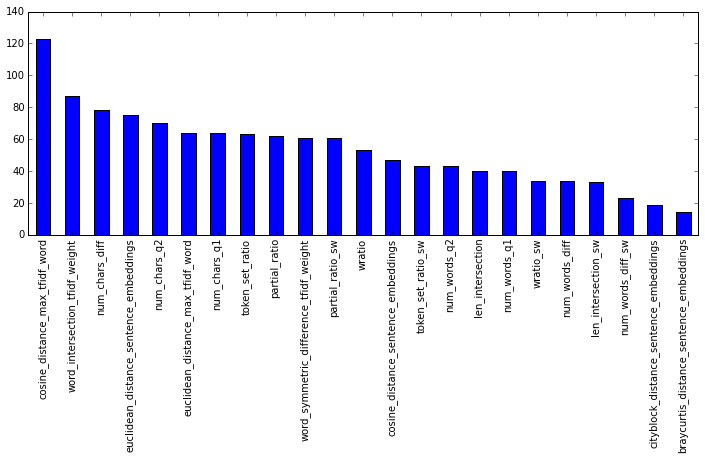

In [168]:
feature_importance(s)